## Project Description
*Cookie Cats* is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. 

As players progress through the game, they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

In this project, we will analyze the result of an **A/B test** where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on **player retention**.

## Acknowledgements
This dataset is taken from DataCamp. Thanks to them for this dataset!

## Workflow:
1. Data Collection
2. Data Pre-Processing and Analysis
3. Statistical Analysis: A/B Testing -- Bootstrapping
4. Conclusion

### Importing the Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Loading the dataset

In [2]:
cookie_users = pd.read_csv('datasets/cookie_cats.csv')

In [3]:
cookie_users.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
cookie_users.shape

(90189, 5)

#### Dataset Content
The data we have includes 90,189 players that installed the game while the A/B test was running. 

#### Variables:

- *userid*: A unique number that identifies each player.

- *version*: Whether the player was put in the control group (gate_30 - a gate at level 30) or the treatment group with the moved gate (gate_40 - a gate at level 40).

- *sum_gamerounds*: the number of game rounds played by the player during the first 14 days after install.

- *retention_1*: Did the player come back and play 1 day after installing?

- *retention_7*: Did the player come back and play 7 days after installing?



### Exploratory Data Analysis

In [5]:
cookie_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
cookie_users.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [7]:
# check missing values
cookie_users.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [8]:
cookie_users.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [9]:
cookie_users.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [10]:
# check if there are repeated users
len(cookie_users.userid.unique())
# also can use: cookie_users["userid"].nunique()

90189

In [11]:
# check if version has some impacts on sum_gamerounds
cookie_users.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


In [12]:
cookie_users.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222944098441,2344795,20034,8502
gate_40,227857702576,2333530,20119,8279


<Figure size 300x300 with 0 Axes>

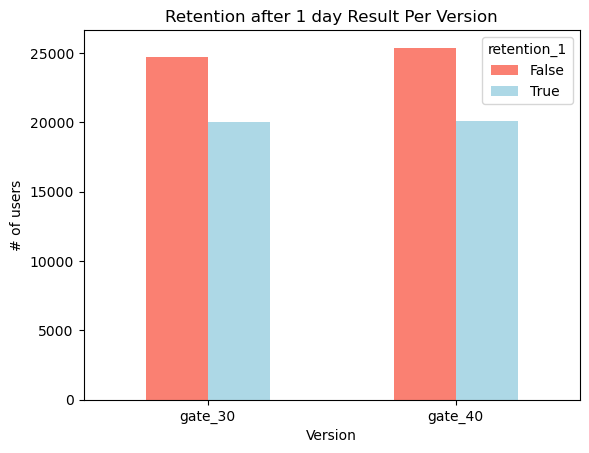

In [20]:
plt.figure(figsize = (3, 3))

# Make the crosstab visual
pd.crosstab(cookie_users.version, cookie_users.retention_1).plot(kind = 'bar', color = ['salmon', 'lightblue'])

# Add some communication
plt.title('Retention after 1 day Result Per Version')
plt.xlabel('Version')
plt.ylabel('# of users')
# plt.legend(['False', 'True'])
plt.xticks(rotation = 0);

<Figure size 300x300 with 0 Axes>

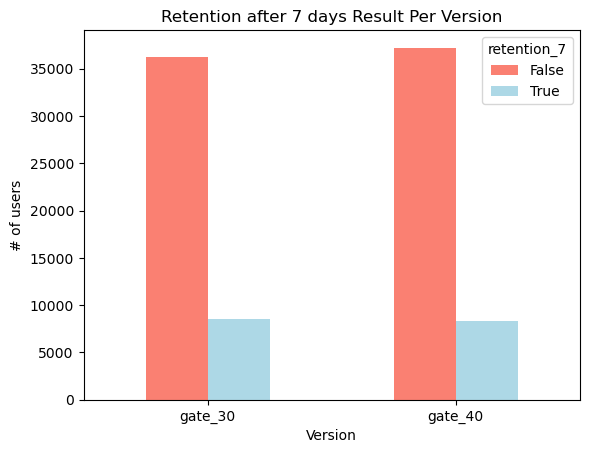

In [21]:
plt.figure(figsize = (3, 3))

# Make the crosstab visual
pd.crosstab(cookie_users.version, cookie_users.retention_7).plot(kind = 'bar', color = ['salmon', 'lightblue'])

# Add some communication
plt.title('Retention after 7 days Result Per Version')
plt.xlabel('Version')
plt.ylabel('# of users')
# plt.legend(['False', 'True'])
plt.xticks(rotation = 0);

### Calculate the Sample Size


In [23]:
cookie_users.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


### How much time do players spend?

Text(0, 0.5, 'userid')

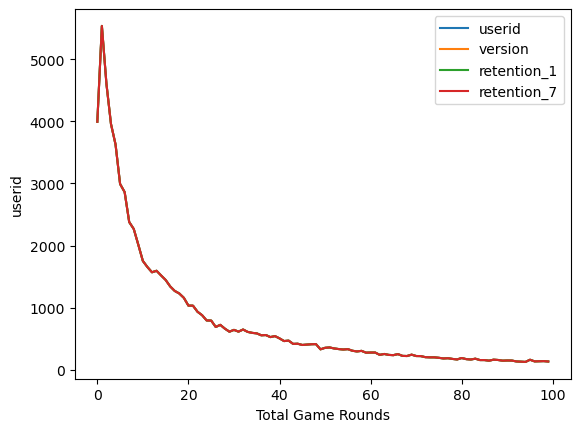

In [24]:
# Counting the number of players for each number of gamerounds 
plot_game = cookie_users.groupby("sum_gamerounds").count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_game[:100].plot()
ax.set_xlabel("Total Game Rounds")
ax.set_ylabel("userid")

It appears that the vast majority of users are playing less than 20 rounds in total, over the recording of this data.

There are also some players that installed the game but never played it (0 game rounds). 

In [48]:
cookie_users[cookie_users['sum_gamerounds'] == 0]['userid'].count()

3994

In [49]:
# the percentage of users that never played the game
cookie_users[cookie_users['sum_gamerounds'] == 0]['userid'].count()/cookie_users['userid'].nunique()

0.0442847797403231

The percentage of players that never played are quite small. Besides, we care more about retention (which we'll talk about later).

Now let’s take the same approach to see if there is much of a difference in the number of games played in our control group and treatment group.

### Group Distributions between groups

#### Set-Up
This time, we’re also going to switch to an overlayed bar-plot of the distinct A/B group distributions.

Since we’ve already identified that the drop off in users occurs in less than 20 sessions, let’s also change our bin distribution to get a more nuanced view of the low-end and high-end of user activities.

In [25]:
plt.style.use('ggplot')

# Counting the number of players for each number of gamerounds 
Group_A = cookie_users[cookie_users.version == 'gate_30']
Group_B = cookie_users[cookie_users.version == 'gate_40']
bins = [0,1,10,20,30,40,50,60,70,80,90,100,200,500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A["sum_gamerounds"], bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B["sum_gamerounds"], bins=bins)).count())

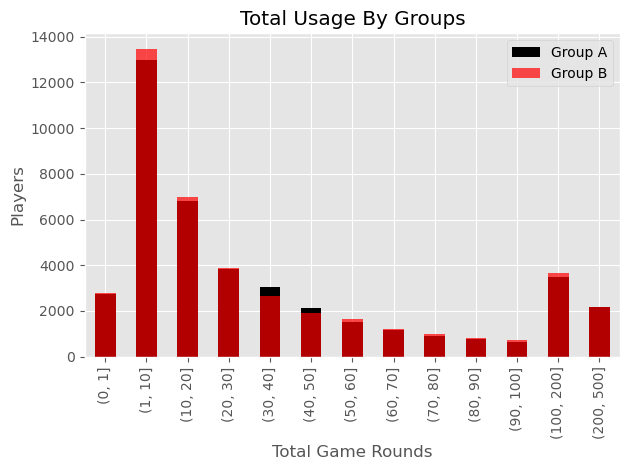

In [28]:
# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_GA[:50].plot(kind = 'bar', y="userid", color = "black", alpha = 1, 
                       title = 'Total Usage By Groups')
plot_GB[:50].plot(kind = 'bar', y="userid", ax=ax, color = "red", alpha = 0.7 )
ax.set_xlabel("Total Game Rounds")
ax.set_ylabel("Players")
# plt.axvline(30, linestyle='dashed', linewidth=2)
# plt.axvline(40, linestyle='dashed', linewidth=2)
plt.legend(["Group A", "Group B"])
plt.tight_layout()
plt.grid(True)

There doesn’t seem to be a large difference between the two versions overall. 

However, there does seem to be some slight disparities around the 30-40 marks that may be related to the A/B test at hand.

#### Try another metric
Another metric we can use to guage the success of the product, is in the capture of **returning users**. 

If our revenue model is based on users, we don’t want them to give up on us early. 

Let’s look at how many players come back the day after installing the game.

In [50]:
# retention for 1-day and 7-days
users_retention = cookie_users[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(users_retention[0],2)}% \
      \n7-days retention ratio: {round(users_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


We can see that a little less than half of the players come back one day after installing the game, while only 18 percent of the players come back 7 day after installing the game.

Now let's look at how retention rates differs between the two A/B groups.

In [51]:
# Calculating 1-day and 7-days retention for each A/B group
users_retention_ab = cookie_users.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
users_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%).

Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%).

Besides, the total time of game played also decrease by 0.48% when the gate was moved to level 40, compared to the control group at level 30. 

In [52]:
# percentage of decreased total gaming time
(users_retention_ab['sum_gamerounds']['gate_40'] - users_retention_ab['sum_gamerounds']['gate_30'])/users_retention_ab['sum_gamerounds']['gate_30']

-0.004804257941525805



We can use **Bootstrapping** to test our confidence about these numbers. 

#### Bootstrapping
**Bootstrapping** is a statistical procedure that resamples a single dataset to create many simulated samples. This process allows us to calculate standard errors, construct confidence intervals, and perform hypothesis testing for numerous types of sample statistics. 

Bootstrap methods are alternative approaches to traditional hypothesis testing and are notable for being easier to understand and valid for more conditions.

##### difference between bootstrapping and traditional hypothesis testing

*Bootstrap hypothesis testing* is a **non-parametric** approach that involves resampling the data to estimate the sampling distribution of a statistic. It is used to estimate the standard error of a statistic, which can be used to construct confidence intervals and perform hypothesis tests. 

On the other hand, *traditional hypothesis testing* involves making assumptions about the distribution of the data and using statistical tests such as t-tests or chi-square tests to test hypotheses.

It is possible that bootstrap hypothesis testing may yield **different** results than traditional hypothesis testing. 

For example, if the sample size is small or if the data does not follow a normal distribution, traditional hypothesis testing may not be appropriate. In such cases, bootstrap hypothesis testing may be more appropriate as it does not rely on assumptions about the distribution of the data.

**Testing Steps**:

1. Creating 500 samples of dataset (bootstraping). Note that in prod, we can use a larger number of samples like 10,000
2. Calculating 1-day & 7-days retentions for A/B groups
3. Plotting the bootstrap distributions
4. Calculating retention rate difference between the two A/B groups
5. Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
6. Evaluating results and making recommendation

In [53]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = cookie_users.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = cookie_users.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

In [84]:
boot_1d.shape, boot_7d.shape

((500, 3), (500, 3))

In [54]:
boot_1d.head()

version,gate_30,gate_40
retention_1,0.453430,0.443314
retention_1,0.441506,0.446356
retention_1,0.447962,0.439063
retention_1,0.448346,0.444009
retention_1,0.442923,0.441387


In [55]:
boot_7d.head()

version,gate_30,gate_40
retention_7,0.188819,0.181309
retention_7,0.187216,0.181069
retention_7,0.188290,0.183737
retention_7,0.189872,0.185040
retention_7,0.191606,0.180773


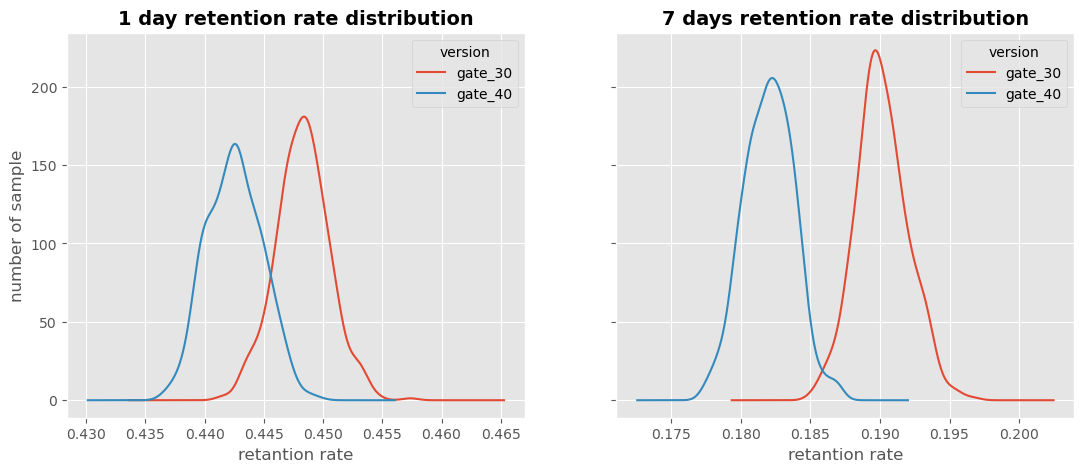

In [56]:
# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day & 7-days retention could be for the two A/B groups. 

Just eyeballing this plot, we can see that there seems to be some evidence of a **difference**, albeit small. 

Let's zoom in on the differences.

In [57]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

In [58]:
boot_1d.head()

version,gate_30,gate_40,diff
retention_1,0.453430,0.443314,2.281865
retention_1,0.441506,0.446356,-1.086582
retention_1,0.447962,0.439063,2.026708
retention_1,0.448346,0.444009,0.976956
retention_1,0.442923,0.441387,0.347990


In [59]:
boot_7d.head()

version,gate_30,gate_40,diff
retention_7,0.188819,0.181309,4.142411
retention_7,0.187216,0.181069,3.394620
retention_7,0.188290,0.183737,2.477887
retention_7,0.189872,0.185040,2.611495
retention_7,0.191606,0.180773,5.992796


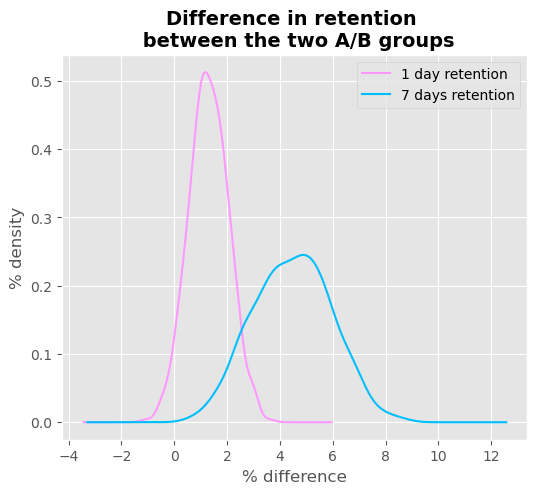

In [60]:
# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

From this plot, we can see that the most likely % difference is around 1% - 2% for 1-day retention. 

For 7-days retention the most likely % difference is around 2% - 5%. 

Moreover, the most of the distribution is above 0%, in favor of a gate at level 30. 

But what is the **probability** that the difference is above 0%? Let's calculate that as well.

In [61]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 97.0%       
The probability that 7-days retention is greater when the gate is at level 30: 100.0% 


In [62]:
prob_7

1.0

### Conclusion

The bootstrap result tells us that there is **strong evidence** that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

The conclusion is: 

- If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. 

There are, of course, other metrics we could look at, like **the number of game rounds played** or how much **in-game purchases** are made by the two groups. But retention is definitely one of the most important metrics.